In [1]:
import os
import joblib
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sweetviz as sv
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor #top1
# from catboost import CatBoostRegressor #top2
# from xgboost import XGBRegressor #top3            

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# get back one folder from current directory
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# df = pd.read_csv('https://github.com/fabioo29/pt-house-price-predict/blob/master/data/houses.csv')
# df = pd.read_csv(os.path.join(base_dir, 'content', 'drive', 'MyDrive', 'Colab Drive', 'houses.csv'))
df = pd.read_csv(os.path.join(base_dir, 'data', 'houses.csv'))

df = df.drop_duplicates(subset=['url'], keep='last')
initial_df = df.copy()

In [3]:
print(df.columns)

Index(['url', 'district', 'county', 'parish', 'type', 'condition',
       'built_area', 'usable_area', 'plot_area', 'rooms', 'bathrooms',
       'energy_efficiency', 'floors', 'fitted_wardrobes', 'air_conditioning',
       'terrace', 'balcony', 'storeroom', 'with_lift', 'swimming_pool',
       'garden', 'garage', 'construction_year', 'heating_type',
       'reduced_mobility', 'price', 'green_area'],
      dtype='object')


In [4]:
# sweetviz initial analysis
# analyze_report = sv.analyze(df)
# analyze_report.show_html('analyze_report_after.html', open_browser=False)

## Feature analysis (drop columns)

In [5]:
removed_list = []
for col in df.columns:
    # drop cols with 15%+ values missing
    if df[col].isnull().sum() / len(df) > 0.15:
        removed_list += [col]
        df.drop(col, axis=1, inplace=True)
        continue

    # drop cols with a unique value (useless to the model)
    if len(df[col].unique()) == 1:
        removed_list += [col]
        df.drop(col, axis=1, inplace=True)

# dropped cols
print(removed_list)

['usable_area', 'plot_area', 'energy_efficiency', 'floors', 'garage', 'construction_year', 'heating_type', 'reduced_mobility']


In [6]:
df.head(2)

,url,district,county,parish,type,condition,built_area,rooms,bathrooms,fitted_wardrobes,air_conditioning,terrace,balcony,storeroom,with_lift,swimming_pool,garden,price,green_area
0,https://www.idealista.pt//en/imovel/31745928/,Lisboa,Sintra,União das freguesias de Massamá e Monte Abraão,Apartment,second hand/needs renovating,86,2,1.0,True,False,False,False,False,False,False,False,"145,000",0.0
1,https://www.idealista.pt//en/imovel/29295165/,Guarda,Guarda,Famalicão,Apartment,second hand/good condition,750,3,2.0,False,False,False,False,False,False,False,False,"49,900",0.0


## Handling missing values

In [7]:
# get cols with missing values
missing_cols = df.columns[df.isnull().any()].tolist()

# print number of missing values and (%) for each col in missing_cols
print(pd.DataFrame({'missing': df[missing_cols].isnull().sum(), '(%)': (df[missing_cols].isnull().sum() / len(df) * 100).astype(int)}))

           missing  (%)
bathrooms      573    1


In [8]:
# drop the 1% rows
df['bathrooms'] = df['bathrooms'].dropna()
df['bathrooms'].describe()

count    35343.000000
mean         2.059305
std          1.168912
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: bathrooms, dtype: float64

<AxesSubplot:xlabel='bathrooms'>

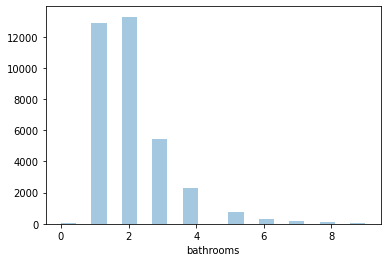

In [9]:
sns.distplot(df['bathrooms'], bins=20, kde=False)

1.0 3.0


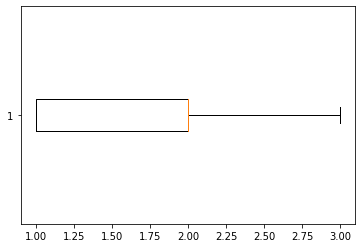

In [10]:
# Remove bathrooms outliers

Q1 = df['bathrooms'].quantile(0.25)
Q3 = df['bathrooms'].quantile(0.75)
IQR = Q3 - Q1

print(Q1, Q3)

filter = (df['bathrooms'] >= Q1) & (df['bathrooms'] <= Q3)

# filter out outliers
df = df[filter]

# box plot price
plt.boxplot(df['bathrooms'], vert=False);

## Feature engineering

#### Condition feature

In [11]:
# print url for each 'condition' value
for x in df['condition'].unique():
    try:
        print(f"{x} | {df[df['condition'] == x].iloc[6]['url']}")
    except:
        print(f'{x} | No house found.')

second hand/needs renovating | https://www.idealista.pt//en/imovel/31614473/
second hand/good condition | https://www.idealista.pt//en/imovel/31744913/
new housing development | https://www.idealista.pt//en/imovel/31752746/
land | No house found.


In [12]:
# all the houses look pretty much the same
df.drop(['condition'], axis=1, inplace=True)

#### Type feature

In [13]:
# check quantity of every unique value in 'type' column
print(df['type'].value_counts())

Apartment              14675
house                   6550
detached house          4867
terrace                 2202
semi-detached house     1470
terraced house          1366
estate                   317
andar de moradia         191
Name: type, dtype: int64


In [14]:
for x in df['type'].unique():
  try:
    print(f"{x} | {df[df['type'] == x].iloc[6]['url']}")
  except:
    print(f'{x} | No house found.')

# url col was only needed until here
df.drop(['url'], axis=1, inplace=True)

Apartment | https://www.idealista.pt//en/imovel/31752100/
terrace | https://www.idealista.pt//en/imovel/31747632/
terraced house | https://www.idealista.pt//en/imovel/30733019/
house | https://www.idealista.pt//en/imovel/31272941/
detached house | https://www.idealista.pt//en/imovel/31706392/
semi-detached house | https://www.idealista.pt//en/imovel/31749210/
estate | https://www.idealista.pt//en/imovel/31249846/
andar de moradia | https://www.idealista.pt//en/imovel/31610853/


In [15]:
# remove warehouses, lands and farms (estate type)
df = df[df['type'] != 'estate']
df['type'] = df['type'].replace(['andar de moradia'], 'Apartment')

In [16]:
# add new feature 'is_apartment'
df['is_apartment'] = df['type'].apply(lambda x: 1 if x == 'Apartment' else 0)

# remove 'type' column
df.drop(['type'], axis=1, inplace=True)

## Transform numerical data

#### Price

In [17]:
# convert price from 1,000.00 to 1000.00
df['price'] = df['price'].str.replace(',', '_').astype('float32')

In [18]:
df['price'].describe()

count    3.132100e+04
mean     2.622701e+05
std      1.293704e+06
min      0.000000e+00
25%      1.000000e+05
50%      1.800000e+05
75%      2.950000e+05
max      1.111110e+08
Name: price, dtype: float64

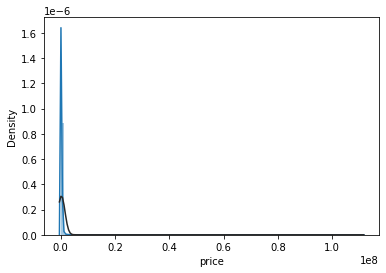

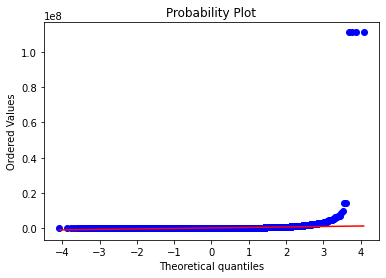

In [19]:
df = df[df['price'] > 0]

sns.distplot(df['price'], bins=100, fit=norm);
fig = plt.figure();
stats.probplot(df['price'], plot=plt);

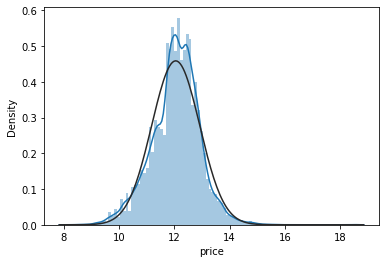

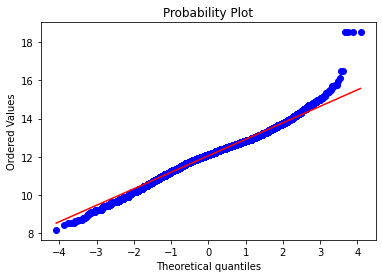

In [20]:
# apply log transformation to price data
df['price'] = np.log(df['price'])

sns.distplot(df['price'], bins=100, fit=norm);
fig = plt.figure();
stats.probplot(df['price'], plot=plt);

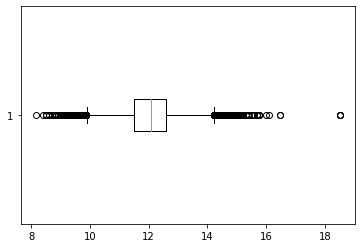

In [21]:
plt.boxplot(df['price'], vert=False);

11.512925148010254 12.594730377197266


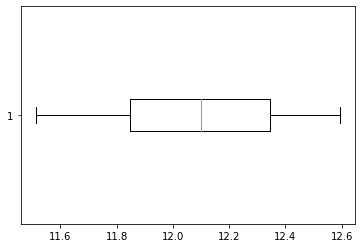

In [22]:
# Remove price outliers

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

print(Q1, Q3)

filter = (df['price'] >= Q1) & (df['price'] <= Q3)

# filter out outliers
df = df[filter]

# box plot price
plt.boxplot(df['price'], vert=False);

#### Built area

In [23]:
df['built_area'].describe()

count    15965.000000
mean       157.149076
std        108.690047
min          0.000000
25%         90.000000
50%        125.000000
75%        190.000000
max        995.000000
Name: built_area, dtype: float64

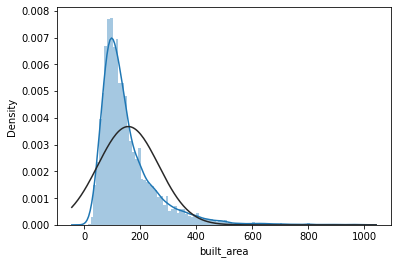

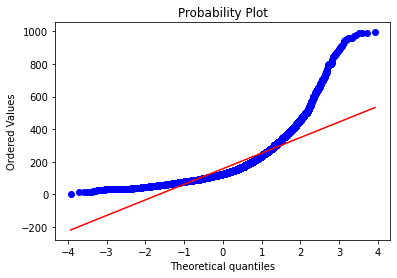

In [24]:
df = df[df['built_area'] > 0]

sns.distplot(df['built_area'], bins=100, fit=norm);
fig = plt.figure();
stats.probplot(df['built_area'], plot=plt);

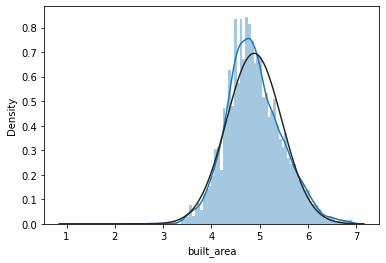

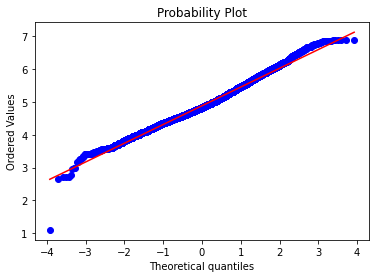

In [25]:
# remove built area == 0 rows
df = df[df['built_area'] > 0]

# apply log transformation to build area data
df['built_area'] = np.log(df['built_area'])

sns.distplot(df['built_area'], bins=100, fit=norm);
fig = plt.figure();
stats.probplot(df['built_area'], plot=plt);

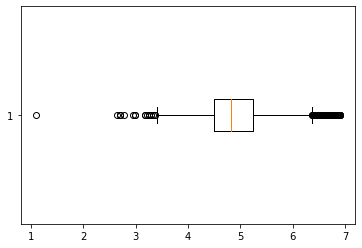

In [26]:
plt.boxplot(df['built_area'], vert=False);

4.499809670330265 5.247024072160486


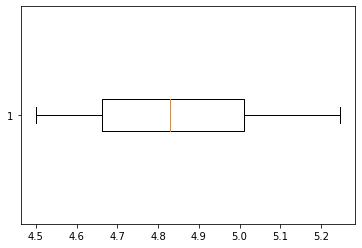

In [27]:
# Remove built area outliers

Q1 = df['built_area'].quantile(0.25)
Q3 = df['built_area'].quantile(0.75)
IQR = Q3 - Q1

print(Q1, Q3)

filter = (df['built_area'] >= Q1) & (df['built_area'] <= Q3)

# filter out outliers
df = df[filter]

# box plot price
plt.boxplot(df['built_area'], vert=False);

## Fix data types

In [28]:
# check features data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 6 to 35911
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   district          8140 non-null   object 
 1   county            8140 non-null   object 
 2   parish            8140 non-null   object 
 3   built_area        8140 non-null   float64
 4   rooms             8140 non-null   int64  
 5   bathrooms         8140 non-null   float64
 6   fitted_wardrobes  8140 non-null   bool   
 7   air_conditioning  8140 non-null   bool   
 8   terrace           8140 non-null   bool   
 9   balcony           8140 non-null   bool   
 10  storeroom         8140 non-null   bool   
 11  with_lift         8140 non-null   bool   
 12  swimming_pool     8140 non-null   bool   
 13  garden            8140 non-null   bool   
 14  price             8140 non-null   float32
 15  green_area        8140 non-null   float64
 16  is_apartment      8140 non-null   int64  

In [29]:
# convert green_area to bool type
df['green_area'] = df['green_area'].astype('bool')
df['is_apartment'] = df['is_apartment'].astype('bool')

In [30]:
# convert data from object type to categorical
categorical_cols = []
for col in df.columns:
    if df[col].dtype == object:
        categorical_cols += [col]
        df[col] = df[col].astype('category')

# changed cols
print(categorical_cols)

['district', 'county', 'parish']


In [31]:
# convert numerical data(int, float) to int32 type feature
numerical_cols = []
for col in df.columns:
    if df[col].dtype in ['int32', 'int64', 'float64']:
        numerical_cols += [col]
        df[col] = df[col].astype('float32')

# changed cols
print(numerical_cols)  

['built_area', 'rooms', 'bathrooms']


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 6 to 35911
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   district          8140 non-null   category
 1   county            8140 non-null   category
 2   parish            8140 non-null   category
 3   built_area        8140 non-null   float32 
 4   rooms             8140 non-null   float32 
 5   bathrooms         8140 non-null   float32 
 6   fitted_wardrobes  8140 non-null   bool    
 7   air_conditioning  8140 non-null   bool    
 8   terrace           8140 non-null   bool    
 9   balcony           8140 non-null   bool    
 10  storeroom         8140 non-null   bool    
 11  with_lift         8140 non-null   bool    
 12  swimming_pool     8140 non-null   bool    
 13  garden            8140 non-null   bool    
 14  price             8140 non-null   float32 
 15  green_area        8140 non-null   bool    
 16  is_apartment      8140 

## Vizualize correlated data

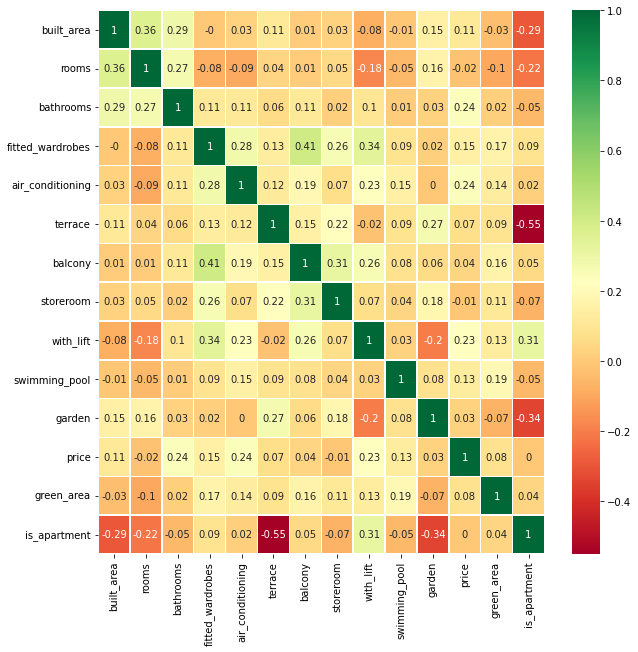

In [33]:
# check correlation between variables
corr = df.corr()

# round correlation values to 2 decimal places
corr = corr.round(2)

# plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.5);

## Encode categorical data

In [34]:
if not os.path.exists(os.path.join(os.path.abspath(base_dir), 'models')):
    os.makedirs(os.path.join(os.path.abspath(base_dir), 'models'))

# encode categorical data with Label Encoder
label_encoder = LabelEncoder()

# use label encoder on categorical features
for col in categorical_cols:
    label_encoder.fit(df[col])
    joblib.dump(label_encoder, os.path.join(base_dir, 'models', 'encoder_' + col + '.joblib'))
    df[col] = label_encoder.transform(df[col])

## Feature scaling

In [35]:
# feature scaling using standard scaler
scaler = StandardScaler()

# use standard scaler on numerical features
for col in numerical_cols:
    scaler.fit(df[col].values.reshape(-1, 1))
    joblib.dump(
        scaler, 
        os.path.join(
            base_dir, 'models', 'scaler_' + col + '.joblib'
        )
    )
    df[col] = scaler.transform(df[col].values.reshape(-1, 1))

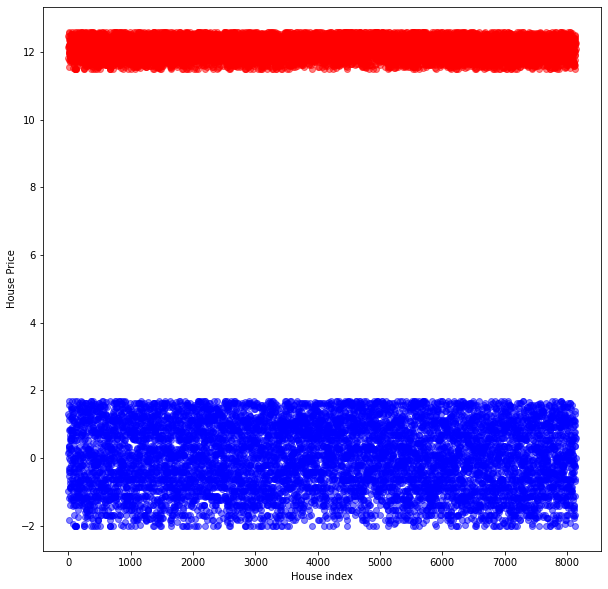

In [36]:
# visualize feature scalling effect on 'price' feature with dots
before = df['price'].values
index = list(range(before.shape[0]))
after = scaler.fit_transform(before.reshape(-1, 1))
plt.figure(figsize=(10, 10))
plt.scatter(index, before, c='red', alpha=0.5);
plt.scatter(index, after, c='blue', alpha=0.5);
plt.xlabel('House index');
plt.ylabel('House Price');
plt.show();

## Final dataset

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 6 to 35911
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   district          8140 non-null   int64  
 1   county            8140 non-null   int64  
 2   parish            8140 non-null   int64  
 3   built_area        8140 non-null   float32
 4   rooms             8140 non-null   float32
 5   bathrooms         8140 non-null   float32
 6   fitted_wardrobes  8140 non-null   bool   
 7   air_conditioning  8140 non-null   bool   
 8   terrace           8140 non-null   bool   
 9   balcony           8140 non-null   bool   
 10  storeroom         8140 non-null   bool   
 11  with_lift         8140 non-null   bool   
 12  swimming_pool     8140 non-null   bool   
 13  garden            8140 non-null   bool   
 14  price             8140 non-null   float32
 15  green_area        8140 non-null   bool   
 16  is_apartment      8140 non-null   bool   

In [38]:
# sweetviz initial analysis
# analyze_report = sv.analyze(df)
# analyze_report.show_html('analyze_report_after.html', open_browser=False)

## Split data

In [39]:
X = df.drop('price',axis =1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [40]:
# check X_train and X_test shape
print(f'Filtered dataset: {len(X)} houses.\n' + \
    'Train data (70%): {X_train.shape}\n' + \
    'Test data (30%): {X_test.shape}')

Filtered dataset: 8140 houses.
Train data (70%): {X_train.shape}
Test data (30%): {X_test.shape}


## Train model

In [41]:
# train model with Random Forest Regressor (top #1)
model = RandomForestRegressor()
model.fit(X_train, y_train);
joblib.dump(model, os.path.join(base_dir, 'models', 'model.joblib'))

['/home/asus-g10ac/Downloads/pt-house-price-predict/models/model.joblib']

## Model evaluation

train metrics: RMSE 20131.95 MAE 14539.57 MAPE 8.0%
test metrics: RMSE 47747.99 MAE 37541.39 MAPE 21.61%


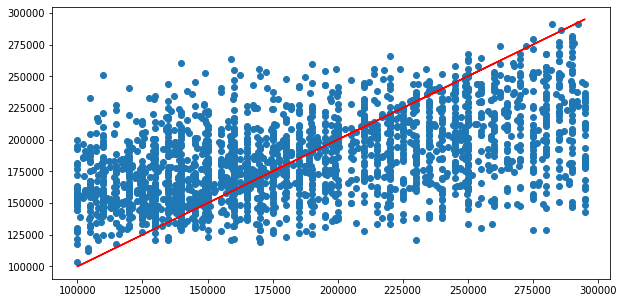

In [42]:
# metrics on train data
y_pred_m = model.predict(X_train)
y_train_m, y_pred_m = np.exp(y_train), np.exp(y_pred_m)
mae_m = mean_absolute_error(y_train_m, y_pred_m)
rmse_m = np.sqrt(mean_squared_error(y_train_m, y_pred_m))
mape_m = np.mean(np.abs((y_train_m - y_pred_m) / y_train_m)) * 100
print(f'train metrics: RMSE {round(rmse_m,2)} MAE {round(mae_m,2)} MAPE {round(mape_m,2)}%')

# metrics on test data
y_pred_m = model.predict(X_test)
y_test_m, y_pred_m = np.exp(y_test), np.exp(y_pred_m)
mae_m = mean_absolute_error(y_test_m, y_pred_m)
rmse_m = np.sqrt(mean_squared_error(y_test_m, y_pred_m))
mape_m = np.mean(np.abs((y_test_m - y_pred_m) / y_test_m)) * 100
print(f'test metrics: RMSE {round(rmse_m,2)} MAE {round(mae_m,2)} MAPE {round(mape_m,2)}%')

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test_m,y_pred_m)
plt.plot(y_test_m,y_test_m,'r')

## Feature selection

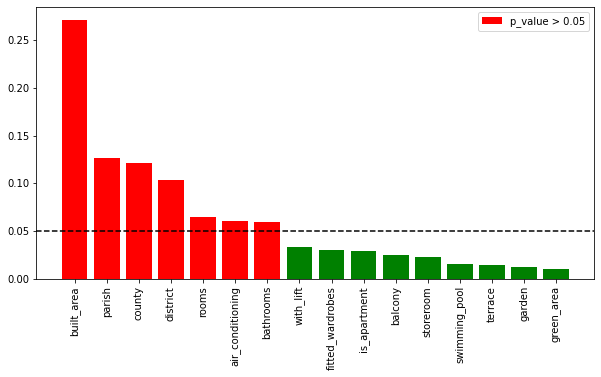

['with_lift', 'fitted_wardrobes', 'is_apartment', 'balcony', 'storeroom', 'swimming_pool', 'terrace', 'garden', 'green_area']


In [43]:
# significant feature level
p_value_threshold = 0.05

# get model features
features = df.drop('price',axis =1).columns

# find most significant features according to the model
importances = model.feature_importances_
df_importances = pd.DataFrame(importances, index=features, columns=['importance'])
df_importances = df_importances.sort_values('importance', ascending=False)
    
# visualize importances (p_values for each feature)
colors = ['red' if p_value > p_value_threshold else 'green' for p_value in df_importances['importance']]
plt.figure(figsize=(10,5))
plt.bar(df_importances.index, df_importances['importance'], color=colors)
plt.legend(['p_value > ' + str(p_value_threshold)])
plt.axhline(y=p_value_threshold, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.show()

# print only statistically significant features (p_value <= p_value_threshold) 
df_importances = df_importances[df_importances['importance'] <= p_value_threshold]
print(list(df_importances.index))

## Model inference

In [44]:
# preprocess house
def predict_price(input_data):
    cols_to_drop = ['url', 'usable_area', 'plot_area', 'energy_efficiency', 'garage']
    cols_to_drop += ['floors', 'construction_year', 'heating_type', 'reduced_mobility'] 
    input_data.drop(cols_to_drop, axis=1, inplace=True)

    input_data['built_area'] = np.log(input_data['built_area'])

    input_data.drop(['condition'], axis=1, inplace=True)
    input_data.drop(['price'], axis=1, inplace=True)

    input_data['is_apartment'] = input_data['type'].apply(lambda x: 1 if x == 'Apartment' else 0)
    input_data.drop(['type'], axis=1, inplace=True)
    
    objects = ['district', 'county', 'parish']
    for col in objects:
        input_data[col] = input_data[col].astype('category')
        label_encoder = joblib.load(os.path.join(base_dir, 'models', 'encoder_' + col + '.joblib'))
        input_data[col] = label_encoder.transform(input_data[col])

    numerical_cols = ['built_area', 'rooms', 'bathrooms']
    for col in numerical_cols:
        scaler = joblib.load(os.path.join(base_dir, 'models', 'scaler_' + col + '.joblib'))
        input_data[col] = scaler.transform(input_data[col].values.reshape(-1, 1))

    input_data = input_data.astype('float32')

    prediction = model.predict(input_data.values)
    prediction = np.exp(prediction[0])
    
    return prediction

In [45]:
df_inference = pd.read_csv(os.path.join(base_dir, 'data', 'houses.csv'))

# model inference
house = df_inference.sample(n=1)  
house_Y = house['price'].values 

price = predict_price(house)

# print house features with price
print(f'Real price: {house_Y[0]}€')
print(f'Predicted price: {int(round(price, -3)):,}€')

ValueError: y contains previously unseen labels: 'Juncal'

In [ ]:
# save test metrics(train, test RMSE MAE) csv to models dir
df_metrics = pd.DataFrame(columns=['train_rmse', 'train_mae', 'test_rmse', 'test_mae'])
df_metrics.loc[0] = [rmse_m, mae_m, rmse_m, mae_m]
df_metrics.to_csv(os.path.join(base_dir, 'models', 'metrics.csv'), index=False)